<a href="https://colab.research.google.com/github/Lisankk/Dirisl_Phase2_PJT/blob/Ito_branch/calculate_auuc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import scipy as sp
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#csvファイルの読み込み
df = pd.read_csv('/content/drive/MyDrive/abtest_results_for_coupon_sending.csv')
df.head()

,sex,recency,history,mens_product_purchase,womens_product_purchase,area_classification,newbie,channel,segment,visit,conversion,spend
0,男性,6,32908,1,1,地方,1,ウェブ,送付なし,0,0,0
1,男性,9,67583,1,0,地方,1,ウェブ,送付あり,0,0,0
2,女性,9,67507,1,1,地方,1,スマートフォン,送付あり,0,0,0
3,男性,2,10164,0,1,都会,0,ウェブ,送付あり,1,0,0
4,女性,4,24142,0,1,地方,1,複数,送付なし,0,0,0


In [4]:
df["sex"] = df["sex"].map({"男性": 0, "女性": 1})
df["segment"] = df["segment"].map({"送付あり": 0, "送付なし": 1})

In [5]:
df_onehot = pd.get_dummies(df[["area_classification", "channel"]], dtype=int)
df = pd.concat([df, df_onehot], axis=1)
df = df.drop(["area_classification", "channel"], axis=1)
df.head()

,sex,recency,history,mens_product_purchase,womens_product_purchase,newbie,segment,visit,conversion,spend,area_classification_地方,area_classification_郊外,area_classification_都会,channel_ウェブ,channel_スマートフォン,channel_複数
0,0,6,32908,1,1,1,1,0,0,0,1,0,0,1,0,0
1,0,9,67583,1,0,1,0,0,0,0,1,0,0,1,0,0
2,1,9,67507,1,1,1,0,0,0,0,1,0,0,0,1,0
3,0,2,10164,0,1,0,0,1,0,0,0,0,1,1,0,0
4,1,4,24142,0,1,1,1,0,0,0,1,0,0,0,0,1


In [6]:
df_RF = df[["recency", "history", "newbie", "segment", "visit"]]
df_RF

,recency,history,newbie,segment,visit
0,6,32908,1,1,0
1,9,67583,1,0,0
2,9,67507,1,0,0
3,2,10164,0,0,1
4,4,24142,1,1,0
...,...,...,...,...,...
42608,7,8646,0,0,1
42609,10,10554,0,0,1
42610,5,3890,1,0,0
42611,6,2999,1,0,1


**ランダムフォレストの実装に当たってクーポンありとなしのグループに分ける**

In [7]:
df_RF_YesKoupon = df_RF[df_RF["segment"] == 0]
df_RF_NoKoupon = df_RF[df_RF["segment"] == 1]

In [8]:
df_RF_YesKoupon = df_RF_YesKoupon.drop("segment", axis = 1)
df_RF_NoKoupon = df_RF_NoKoupon.drop("segment", axis = 1)



---
以下より、クーポンありモデルについて、交差検証ありのRandom Forestの実装を進めていく。


**交差検証の実装(クーポンあり)**

In [9]:
# 学習モデルを作成
model = RandomForestClassifier(random_state=42)

# 説明変数と目的変数の定義
X_yes_coupon = df_RF_YesKoupon[["recency", "history", "newbie"]]
y_yes_coupon = df_RF_YesKoupon["visit"]

# クロスバリデーションの実行
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_yes_coupon = cross_val_score(model, X_yes_coupon, y_yes_coupon, cv=kf, scoring='roc_auc') # 評価指標にはAUCを使用

print(f'Cross-Validation AUC (各フォールドに対して): {scores_yes_coupon}')
print(f'Cross-Validation AUC (平均): {scores_yes_coupon.mean()}')

Cross-Validation AUC (各フォールドに対して): [0.92122285 0.92361279 0.92581986 0.92480975 0.92297242]
Cross-Validation AUC (平均): 0.9236875351962113


**oof算出処理 (クーポンあり)**

In [10]:
# oof予測値を格納する配列
oof_predictions_yes_coupon = np.zeros(X_yes_coupon.shape[0])

# クロスバリデーションの実行
for train_index, val_index in kf.split(X_yes_coupon):
  X_train_yes_cv, X_val_yes = X_yes_coupon.iloc[train_index], X_yes_coupon.iloc[val_index]
  y_train_yes, y_test_yes = y_yes_coupon.iloc[train_index], y_yes_coupon.iloc[val_index]

  # モデル学習
  model.fit(X_train_yes_cv, y_train_yes)

  # oof予測値の保存
  oof_predictions_yes_coupon[val_index] = model.predict_proba(X_val_yes)[:, 1]

# OOFスコア（AUCを使用）を計算
oof_score_yes_coupon = roc_auc_score(y_yes_coupon, oof_predictions_yes_coupon)
print(f'OOF AUC Score: {oof_score_yes_coupon}')

OOF AUC Score: 0.9236210709406577


**評価 (クーポンあり)**

In [11]:
# 交差検証なしの実装の時と同じ方法でデータを分割
X_train_yes, X_test_yes, t_train_yes, t_test_yes = train_test_split(
    df_RF_YesKoupon[["recency", "history", "newbie"]],
    df_RF_YesKoupon["visit"],
    test_size=0.3,
    random_state=0
)

AUC (CVあり): 0.9232549033139061
正解率 (CVあり): 83.78%
適合率 (CVあり): 87.86%
再現率 (CVあり): 85.99%
F1 (CVあり): 86.91%


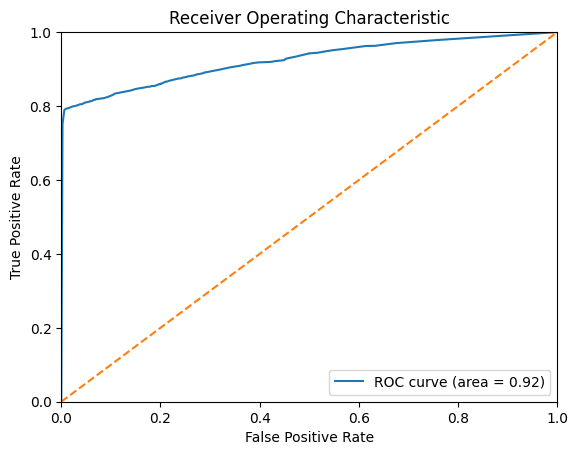

In [12]:
# 訓練データ全体でモデルを再訓練
model.fit(X_train_yes, t_train_yes)

# テストデータでの予測
test_predictions_yes_coupon = model.predict_proba(X_test_yes)[:, 1]

# テストデータでのAUC評価
test_auc_yes_coupon = roc_auc_score(t_test_yes, test_predictions_yes_coupon)
print(f'AUC (CVあり): {test_auc_yes_coupon}')

# テストデータでのその他の評価指標の計算
test_preds_binary = model.predict(X_test_yes)
score_cv = accuracy_score(t_test_yes, test_preds_binary)
precision_cv = precision_score(t_test_yes, test_preds_binary)
recall_cv = recall_score(t_test_yes, test_preds_binary)
f1_cv = f1_score(t_test_yes, test_preds_binary)
print(f"正解率 (CVあり): {score_cv * 100:.2f}%")
print(f"適合率 (CVあり): {precision_cv * 100:.2f}%")
print(f"再現率 (CVあり): {recall_cv * 100:.2f}%")
print(f"F1 (CVあり): {f1_cv * 100:.2f}%")

# ROC曲線の描画
fpr, tpr, thresholds = roc_curve(t_test_yes, test_predictions_yes_coupon)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % test_auc_yes_coupon)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

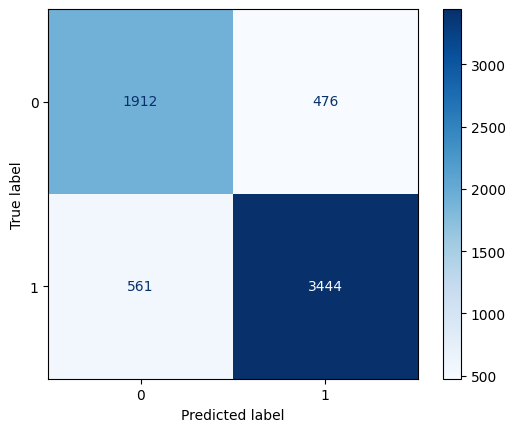

In [13]:
# 混同行列
cm = confusion_matrix(t_test_yes, test_preds_binary)
cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmp.plot(cmap=plt.cm.Blues)


---
クーポンなしモデルについて、交差検証ありの実装

**交差検証の実装(クーポンなし)**



In [14]:
# 学習モデルを作成
model = RandomForestClassifier(random_state=42)

# 説明変数と目的変数の定義
X = df_RF_NoKoupon[["recency", "history", "newbie"]]
y = df_RF_NoKoupon["visit"]

# クロスバリデーションの実行
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc') # 評価指標にはAUCを使用

print(f'Cross validation scores: {scores.mean()}')

Cross validation scores: 0.6433457078408645


**oof算出処理の実装**



In [15]:

Z = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X):
  # oof予測値を格納する配列
  oof_predictions = np.zeros(X.shape[0])
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_test = y.iloc[train_index], y.iloc[val_index]

# モデル学習
  model.fit(X_train, y_train)

# oof予測値の保存
  oof_predictions = model.predict_proba(X_val)[:, 1]
  oof_predictions = pd.DataFrame(oof_predictions)


# OOFスコア（AUCを使用）を計算
  oof_score = roc_auc_score(y_test, oof_predictions)
  print(f'OOF AUC Score: {oof_score}')

# OOF予測値を保存
  Z.append(oof_score)


OOF AUC Score: 0.642559856723534
OOF AUC Score: 0.6382034370928705
OOF AUC Score: 0.6573899787743648
OOF AUC Score: 0.6434249367245574
OOF AUC Score: 0.6351503298889958


In [16]:
pd.DataFrame(Z).mean()

,0
0,0.643346


In [17]:
X.shape[0]

21306

**評価**

**クーポンなしの実装**

AUC (CVあり): 0.6398533085145779
正解率 (CVあり): 63.89%
適合率 (CVあり): 44.19%
再現率 (CVあり): 40.04%
F1 (CVあり): 42.01%


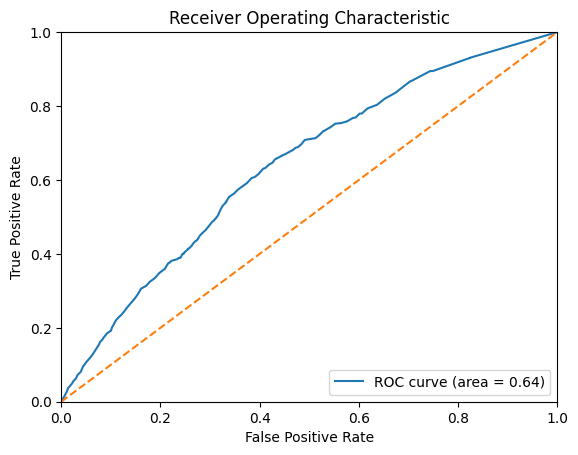

In [18]:
# 交差検証なしの実装の時と同じ方法でデータを分割
X_train, X_test, t_train, t_test = train_test_split(
    df_RF_NoKoupon[["recency", "history", "newbie"]],
    df_RF_NoKoupon["visit"],
    test_size=0.3,
    random_state=0
)

# 訓練データ全体でモデルを再訓練
model.fit(X_train, t_train)

# テストデータでの予測
test_predictions = model.predict_proba(X_test)[:, 1]

# テストデータでのAUC評価
test_auc = roc_auc_score(t_test, test_predictions)
print(f'AUC (CVあり): {test_auc}')

# テストデータでのその他の評価指標の計算
test_preds_binary = model.predict(X_test)
score_cv = accuracy_score(t_test, test_preds_binary)
precision_cv = precision_score(t_test, test_preds_binary)
recall_cv = recall_score(t_test, test_preds_binary)
f1_cv = f1_score(t_test, test_preds_binary)
print(f"正解率 (CVあり): {score_cv * 100:.2f}%")
print(f"適合率 (CVあり): {precision_cv * 100:.2f}%")
print(f"再現率 (CVあり): {recall_cv * 100:.2f}%")
print(f"F1 (CVあり): {f1_cv * 100:.2f}%")

# ROC曲線の描画
fpr, tpr, thresholds = roc_curve(t_test, test_predictions)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % test_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**AUUCの算出**

クーポンあり、クーポンなしそれぞれのテストデータのサイズが一致していなかったので、一致するように調整

In [45]:
# テストデータのサイズを一致させるために、最小の共通インデックスを使用
min_test_size = min(len(X_test_yes), len(X_test))

X_test_yes = X_test_yes.iloc[:min_test_size]
t_test_yes = t_test_yes.iloc[:min_test_size]
X_test = X_test.iloc[:min_test_size]
t_test = t_test.iloc[:min_test_size]

# クーポンありモデルの予測
test_predictions_yes = model.predict_proba(X_test_yes)[:, 1]

# クーポンなしモデルの予測
test_predictions_no = model.predict_proba(X_test)[:, 1]

# 予測結果の形状を確認
print(f"クーポンありの予測結果の形状: {test_predictions_yes.shape}")
print(f"クーポンなしの予測結果の形状: {test_predictions_no.shape}")

# Uplift Scoreの計算
uplift_scores = test_predictions_yes - test_predictions_no

クーポンありの予測結果の形状: (6392,)
クーポンなしの予測結果の形状: (6392,)


In [46]:
# 確認
print(f"クーポンありのテストデータの形状: {X_test_yes.shape}")
print(f"クーポンなしのテストデータの形状: {X_test.shape}")
print(f"Uplift Scoreの形状: {uplift_scores.shape}")
print(f"クーポンありの目的変数の形状: {t_test_yes.shape}")
print(f"クーポンなしの目的変数の形状: {t_test.shape}")

クーポンありのテストデータの形状: (6392, 3)
クーポンなしのテストデータの形状: (6392, 3)
Uplift Scoreの形状: (6392,)
クーポンありの目的変数の形状: (6392,)
クーポンなしの目的変数の形状: (6392,)


必要なデータの準備

In [44]:
# クーポンあり・なしのフラグを作成
visit_flg = np.concatenate([t_test_yes, t_test])
treat_flg = np.concatenate([np.ones(len(t_test_yes)), np.zeros(len(t_test))])

# 検証データの準備
test_data = pd.DataFrame({
    'cv_flg': visit_flg,
    'treat_flg': treat_flg,
    'uplift_score': uplift_scores
})

# uplift score が大きい順に検証データを並び替え
result = test_data.sort_values(by='uplift_score', ascending=False).reset_index(drop=True)

ValueError: All arrays must be of the same length

AUUCの計算

In [ ]:
# lift の算出
result['treat_num_cumsum'] = result['treat_flg'].cumsum()
result['control_num_cumsum'] = (1 - result['treat_flg']).cumsum()
result['treat_visit_cumsum'] = (result['treat_flg'] * result['cv_flg']).cumsum()
result['control_visit_cumsum'] = ((1 - result['treat_flg']) * result['cv_flg']).cumsum()
result['treat_cvr'] = (result['treat_visit_cumsum'] / result['treat_num_cumsum']).fillna(0)
result['control_cvr'] = (result['control_visit_cumsum'] / result['control_num_cumsum']).fillna(0)
result['lift'] = (result['treat_cvr'] - result['control_cvr']) * result['treat_num_cumsum']
result['base_line'] = result.index * result['lift'].iloc[-1] / len(result.index)

# AUUC の算出
auuc = (result['lift'] - result['base_line']).sum() / len(result['lift'])
print('AUUC = {:.2f}'.format(auuc))

In [ ]:
# グラフの描画
result.plot(y=['lift', 'base_line'])
plt.xlabel('uplift score rank')
plt.ylabel('visit lift')
plt.show()